<a href="https://colab.research.google.com/github/g150446/colab/blob/main/nmt_with_attention_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# アテンションを用いたニューラル機械翻訳

Note: これらのドキュメントは私たちTensorFlowコミュニティが翻訳したものです。コミュニティによる 翻訳は**ベストエフォート**であるため、この翻訳が正確であることや[英語の公式ドキュメント](https://www.tensorflow.org/?hl=en)の 最新の状態を反映したものであることを保証することはできません。 この翻訳の品質を向上させるためのご意見をお持ちの方は、GitHubリポジトリ[tensorflow/docs](https://github.com/tensorflow/docs)にプルリクエストをお送りください。 コミュニティによる翻訳やレビューに参加していただける方は、 [docs-ja@tensorflow.org メーリングリスト](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ja)にご連絡ください。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

このノートブックでは、スペイン語から英語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。このチュートリアルは、 Sequence to Sequence モデルの知識があることを前提にした上級編のサンプルです。

このノートブックのモデルを訓練すると、_"¿todavia estan en casa?"_  のようなスペイン語の文を入力して、英訳：  _"are you still at home?"_  を得ることができます。

この翻訳品質はおもちゃとしてはそれなりのものですが、生成されたアテンションの図表の方が面白いかもしれません。これは、翻訳時にモデルが入力文のどの部分に注目しているかを表しています。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: このサンプルは P100 GPU 1基で実行した場合に約 10 分かかります。

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## データセットのダウンロードと準備

ここでは、http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには、次のような書式の言語翻訳ペアが含まれています。


```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

さまざまな言語が用意されていますが、ここでは英語ースペイン語のデータセットを使用します。利便性を考えてこのデータセットは Google Cloud 上に用意してありますが、ご自分でダウンロードすることも可能です。データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [3]:
# ファイルのダウンロード
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 1s 0us/step


In [10]:
print(path_to_file)

with open(path_to_file) as file:
  ct =0
  for line in file:
    ct = ct +1
    if len(line) > 200:
      print(line.replace('\t', ' ') )
  print(ct)

/root/.keras/datasets/spa-eng/spa.txt
Tom liked Mary for years, but at some point, his feelings for her changed to love. A Tom le había gustado Mary desde hacía varios años, pero, en algún momento, sus sentimientos hacia ella se convirtieron en amor.

Experts say coffee prices are rising mainly because people are willing to pay more. Los expertos declaran que los precios del café están subiendo fundamentalmente porque la gente está dispuesta a pagar más.

The Titanic's lifeboats only had enough space to carry about half of those on board. Los botes salvavidas del Titanic solo tenían espacio suficiente para llevar a cerca de la mitad de los que iban a bordo.

A pre-dawn raid has netted a large stash of illegal steroids and several bags of cash. Una incursión antes del amanecer ha incautado una gran reserva de esteroides ilegales y varias bolsas de dinero en efectivo.

Tom was charged with drunken driving after he was involved in a car accident in Boston. Acusaron a Tom de conducir bajo 

In [ ]:
# ユニコードファイルを ascii に変換
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 単語とそのあとの句読点の間にスペースを挿入
    # 例：　"he is a boy." => "he is a boy ."
    # 参照：- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, ".", "?", "!", ",") 以外の全ての文字をスペースに置き換え
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. アクセント記号を除去
# 2. 文をクリーニング
# 3. [ENGLISH, SPANISH] の形で単語のペアを返す
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 実験を速くするためデータセットのサイズを制限（オプション）

100,000 を超える文のデータセットを使って訓練するには長い時間がかかります。訓練を速くするため、データセットのサイズを 30,000 に制限することができます（もちろん、データが少なければ翻訳の品質は低下します）。

In [ ]:
# このサイズのデータセットで実験
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1858 ----> hazte
1236 ----> cargo
14 ----> de
30 ----> esto
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
94 ----> take
436 ----> care
59 ----> of
19 ----> this
3 ----> .
2 ----> <end>


### tf.data データセットの作成

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## エンコーダー・デコーダーモデルの記述

TensorFlow の [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt) に記載されているアテンション付きのエンコーダー・デコーダーモデルを実装します。この例では、最新の API セットを使用します。このノートブックは、上記の seq2seq チュートリアルにある [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) を実装します。下図は、入力の単語ひとつひとつにアテンション機構によって重みが割り当てられ、それを使ってデコーダーが文中の次の単語を予測することを示しています。下記の図と式は [Luong の論文](https://arxiv.org/abs/1508.04025v5) にあるアテンション機構の例です。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

入力がエンコーダーを通過すると、shape が *(batch_size, max_length, hidden_size)* のエンコーダー出力と、shape が *(batch_size, hidden_size)* のエンコーダーの隠れ状態が得られます。

下記に実装されている式を示します。

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

このチュートリアルでは、エンコーダーでは [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) を使用します。簡略化した式を書く前に、表記方法を定めましょう。

* FC = 全結合 (Dense) レイヤー
* EO = エンコーダーの出力
* H = 隠れ状態
* X = デコーダーへの入力


擬似コードは下記のとおりです。

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`　softmax は既定では最後の軸に対して実行されますが、スコアの shape が *(batch_size, max_length, hidden_size)*　であるため、*最初の軸* に適用します。`max_length` は入力の長さです。入力それぞれに重みを割り当てようとしているので、softmax はその軸に適用されなければなりません。
* `context vector = sum(attention weights * EO, axis = 1)`. 上記と同様の理由で axis = 1 に設定しています。
* `embedding output` = デコーダーへの入力 X は Embedding レイヤーを通して渡されます。
* `merged vector = concat(embedding output, context vector)`
* この結合されたベクトルがつぎに GRU に渡されます。

それぞれのステップでのベクトルの shape は、コードのコメントに指定されています。

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## オプティマイザと損失関数の定義

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## チェックポイント（オブジェクトベースの保存）

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 訓練

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing - 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # Teacher Forcing を使用
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6630
Epoch 1 Batch 100 Loss 2.1138
Epoch 1 Batch 200 Loss 1.8655
Epoch 1 Batch 300 Loss 1.7391
Epoch 1 Loss 2.0416
Time taken for 1 epoch 49.914024114608765 sec

Epoch 2 Batch 0 Loss 1.5678
Epoch 2 Batch 100 Loss 1.4255
Epoch 2 Batch 200 Loss 1.3429
Epoch 2 Batch 300 Loss 1.3561
Epoch 2 Loss 1.4095
Time taken for 1 epoch 26.94392418861389 sec

Epoch 3 Batch 0 Loss 1.0680
Epoch 3 Batch 100 Loss 1.0243
Epoch 3 Batch 200 Loss 0.9542
Epoch 3 Batch 300 Loss 0.8600
Epoch 3 Loss 0.9937
Time taken for 1 epoch 26.04426336288452 sec

Epoch 4 Batch 0 Loss 0.7221
Epoch 4 Batch 100 Loss 0.7003
Epoch 4 Batch 200 Loss 0.6542
Epoch 4 Batch 300 Loss 0.6888
Epoch 4 Loss 0.6844
Time taken for 1 epoch 26.60863161087036 sec

Epoch 5 Batch 0 Loss 0.4634
Epoch 5 Batch 100 Loss 0.4026
Epoch 5 Batch 200 Loss 0.4833
Epoch 5 Batch 300 Loss 0.4197
Epoch 5 Loss 0.4710
Time taken for 1 epoch 26.588965892791748 sec

Epoch 6 Batch 0 Loss 0.3072
Epoch 6 Batch 100 Loss 0.3494
Epoch 6 Batch 200 Lo

## 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが *終了トークン* を予測したら、予測を停止する。
* また、*タイムステップごとのアテンションの重み*　を保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 最後のチェックポイントを復元しテストする

In [ ]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s pretty cold . <end> 


<ipython-input-28-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-28-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


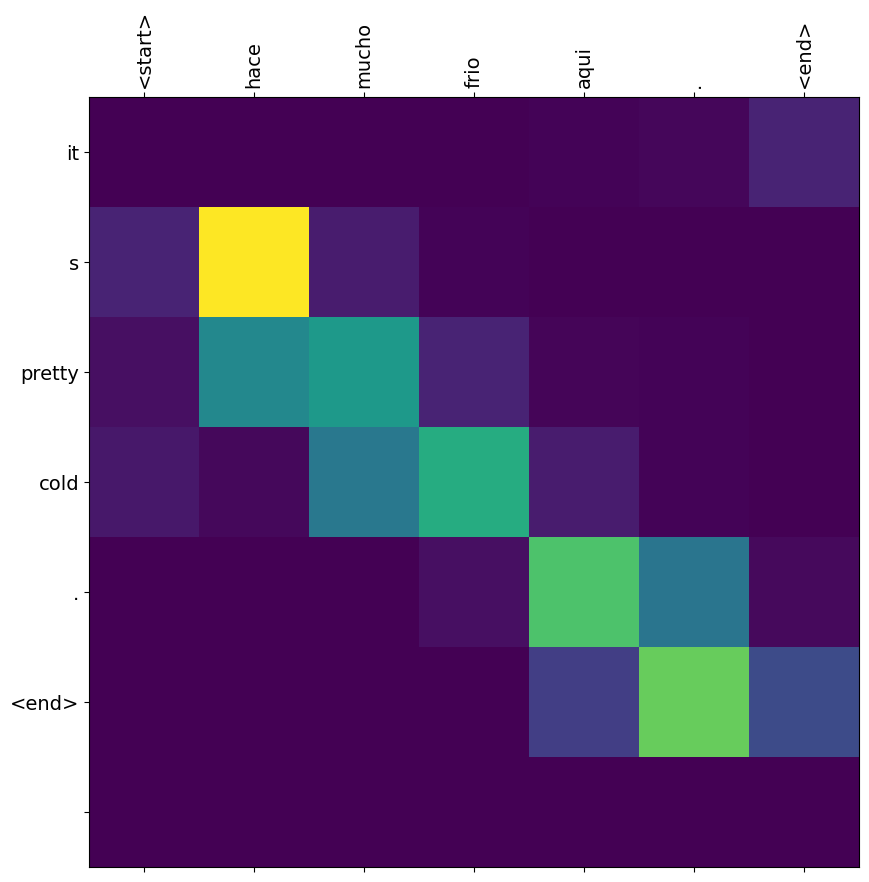

In [ ]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-28-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-28-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


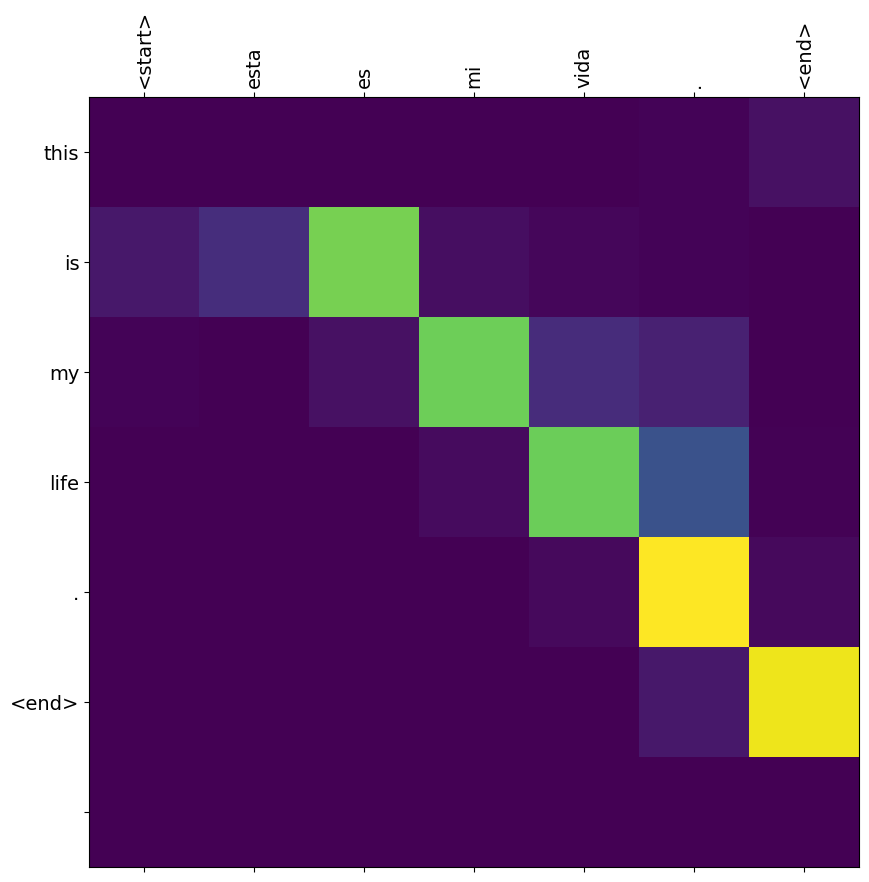

In [ ]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


<ipython-input-28-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-28-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


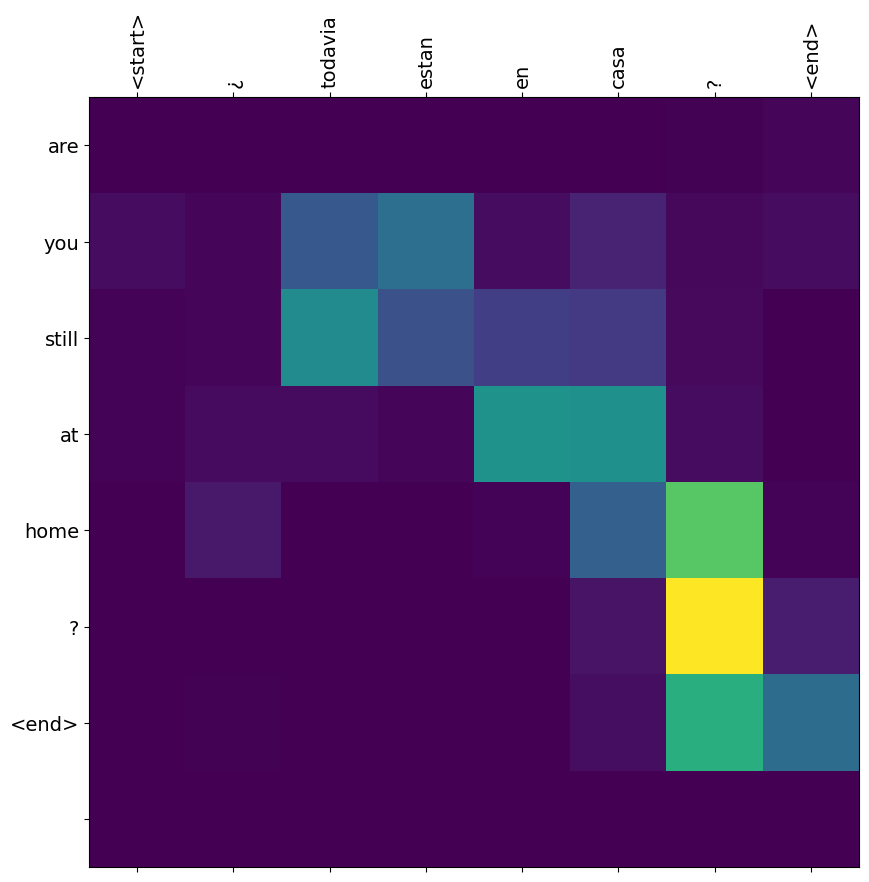

In [ ]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


<ipython-input-28-5ef4cab55ead>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-28-5ef4cab55ead>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


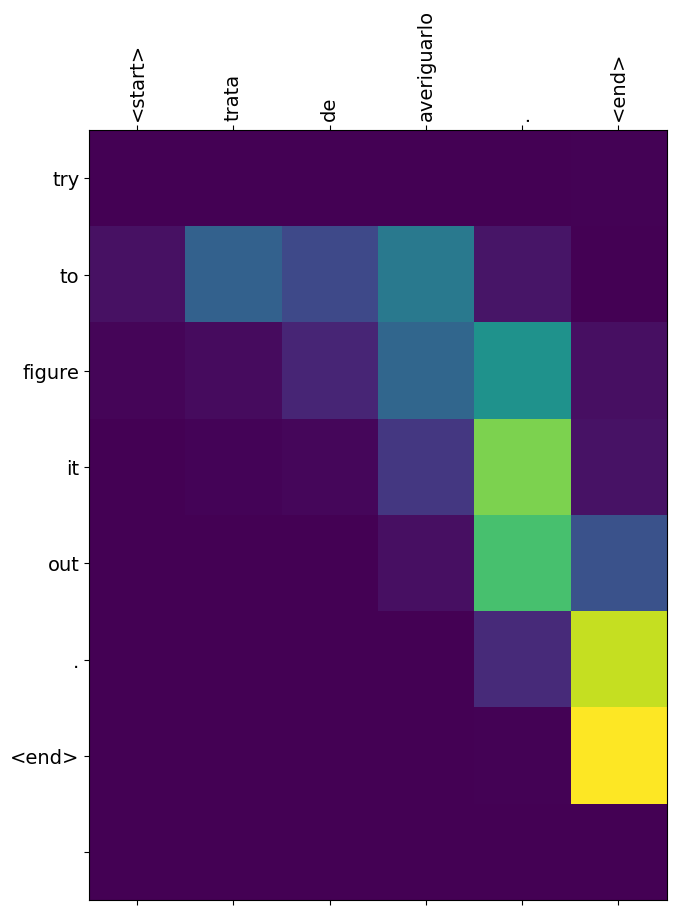

In [ ]:
# 翻訳あやまりの例
translate(u'trata de averiguarlo.')

## 次のステップ

* [異なるデータセットをダウンロード](http://www.manythings.org/anki/)して翻訳の実験を行ってみよう。たとえば英語からドイツ語や、英語からフランス語。
* もっと大きなデータセットで訓練を行ったり、もっと多くのエポックで訓練を行ったりしてみよう。